<a href="https://colab.research.google.com/github/vijayshankarrealdeal/GoogleColab/blob/main/KaggleHouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
df  = pd.read_csv('/content/train.csv')
def pre_porcess(df,test = False):
  df.drop(['Alley','PoolQC','Fence','MiscFeature','GarageQual'],axis = 1,inplace = True)
  val = ['OverallQual','OverallCond','YearBuilt','LotArea','SaleCondition','GarageCars','GarageArea','MSSubClass','LotArea','Neighborhood']
  lk = df[val]
  di = ['SaleCondition','Neighborhood']
  for val in di:
    one_hot = pd.get_dummies(lk[val])
    lk = lk.drop(val,axis = 1)
    lk = lk.join(one_hot.iloc[:,1:])
  if test:
    lk.GarageCars = lk.GarageCars.fillna(df.GarageCars.mean())
    lk.GarageArea = lk.GarageArea.fillna(df.GarageArea.mean())
  return lk 
Y = df.SalePrice

In [66]:
lk = pre_porcess(df)


In [67]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [68]:
X = lk.values

In [69]:
X = scaler.fit_transform(X)

In [70]:
X.shape

(1460, 37)

In [71]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,Y.values,random_state = 42,test_size = 0.2)

In [72]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor()
regressor.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [73]:
test_df = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')
test_d = pre_porcess(test_df,test=True)

In [74]:
test_d.shape

(1459, 37)

In [75]:
test_d = scaler.fit_transform(test_d.values)

In [76]:
predict = regressor.predict(test_d)

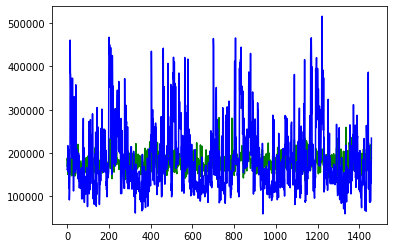

In [81]:
plt.plot(sub.SalePrice.values,color = 'g')
plt.plot(predict,color = 'r')
plt.show()

In [ ]:
test_d = torch.from_numpy(test_d.astype(np.float32)).to(device)

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [9]:
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')

In [10]:
X_train = torch.from_numpy(x_train.astype(np.float32)).to(device)
Y_train = torch.from_numpy(y_train.astype(np.float32)).to(device)
X_test = torch.from_numpy(x_test.astype(np.float32)).to(device)
Y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

In [11]:
class Model(nn.Module):
  def __init__(self,input_layer = 41,hidden_units = 64,output_dim = 1):
    super(Model,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(input_layer,hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units,hidden_units*2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_units*2,hidden_units*4),
        nn.Dropout(0.2),
        nn.ReLU(),
        nn.Linear(hidden_units*4,1)
    )

  def forward(self,x):
    return self.model(x)

In [12]:
loss_fn = nn.MSELoss()
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)

In [13]:
n_epochs = 750
batch_size = 128
train_losses = []
test_losses = []
for ep in range(n_epochs):
  permutation = torch.randperm(X_train.size()[0])
  train_loss = []
  for i in range(0,X_train.size()[0], batch_size):
    optimizer.zero_grad()
    indices = permutation[i:i+batch_size]
    batch_x, batch_y = X_train[indices], Y_train[indices]
    outputs = model(batch_x).squeeze()
    loss = loss_fn(outputs,batch_y)
    train_loss.append(loss.item())
    loss.backward()
    optimizer.step()
  train_loss = np.mean(train_loss)

  permutation_test = torch.randperm(X_test.size()[0])
  test_loss = []
  for i in range(0,X_test.size()[0], batch_size):
    indices_test = permutation_test[i:i+batch_size]
    batch_x_test, batch_y_test = X_test[indices_test], Y_test[indices_test]
    outputs = model(batch_x_test).squeeze()
    loss = loss_fn(outputs,batch_y_test)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses.append(train_loss)
  test_losses.append(test_loss)

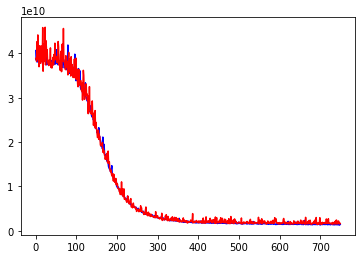

In [14]:
plt.plot(train_losses,color = 'b')
plt.plot(test_losses,color = 'r')
plt.show()

In [16]:
with torch.no_grad():
  pred = model(test_d)
pred = np.array(pred.cpu())

In [17]:
pred,sub =  pred.squeeze(),X_VAl.squeeze()

In [18]:
pred[200],sub[200]

(17544620.0, 201912.27062288302)

In [19]:
n_correct = 0
n_total = sub.shape[0]
for i in range(n_total):
  if pred[i] == sub[i]:
    n_correct += 1

print(f'Accuracy {n_correct/n_total}')

Accuracy 0.0


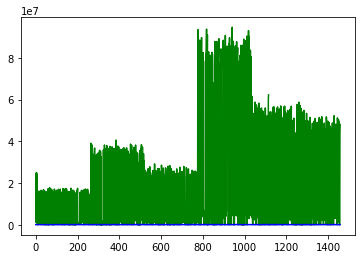

In [20]:
plt.plot(range(len(pred)),pred,color = 'g')
plt.plot(range(len(sub)),sub,color = 'b')
plt.show()